# Environment — CartPole-v1

The objective is that, by means of the inertia generated by the cart in its horizontal displacements, the pole remains vertical as long as possible. An episode is considered successful when the pole remains vertical for more than 500 timesteps, and an episode is considered unsuccessful if the cart runs off the horizontal guide on the right or left side, or if the pole tilts more than 12 degrees (~0.2095 radians) with respect to the vertical axis.

It should be noted that, although the allowed value ranges are those shown in the table, an episode will be terminated if:

The Cart position on the x axis leaves the (-2.4, 2.4) range
The Pole angle leaves the (-0.2095, 0.2095) range
Rewards
The agent receives a reward of +1 for each time step, with the intention of keeping the pole standing for as long as possible.

In [118]:
import json
import random
import time
from collections import deque

import gym
import keras
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation as animation

The Replay Buffer is implemented as a double-ended queue (deque), and two methods are created to interact with it: save_experience() and sample_experience_batch(). save_experience() allows adding an experience to the replay buffer, while sample_experience_batch() randomly picks up a batch of experiences, which will be used to train the agent. The batch of experiences is returned as a tuple of (states, actions, rewards, next_states, terminals), where each element in the tuple corresponds to an array of {batch_size} items.

# we use the self at the beginning of each define funtion in order to include it in the object class. 

In [167]:
class DQNAgent:
    
        def __init__(self, state_size, action_size):

            self.state_size = state_size
            self.action_size = action_size

            # Initialize Replay Buffer as python deque
            self.replay_buffer = deque(maxlen=100000)

            # Set algorithm hyperparameters
            self.gamma = 0.99
            self.epsilon = 1.
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.98
            self.learning_rate = 0.001
            self.update_rate = 10
            # Create both Main and Target Networks
            self.main_network = self.create_nn()
            self.target_network = self.create_nn()
            # Initialize Target Network with Main Network's weights
            self.update_target_network()
            #Creating the neural network. 
        def create_nn(self):
        
            model = Sequential()

            model.add(Dense(64, activation='relu', input_dim=self.state_size))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(self.action_size, activation='linear'))
            #this is a continous data so we use 'MSE' as the loss function. 
            model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))

            return model
         
    
        def update_target_network(self):
            # Method to set the Main NN's weights on the Target NN
            self.target_network.set_weights(self.main_network.get_weights())
        
        

        def save_experience(self, state, action, reward, next_state, terminal):

            # Save the given experience as a (s, a, r, s', terminal) tuple
            self.replay_buffer.append((state, action, reward, next_state, terminal))

        def sample_experience_batch(self, batch_size):

            # Sample {batchsize} experiences from the ReplayBuffer
            exp_batch = random.sample(self.replay_buffer, batch_size)

            # Create an array with the {batchsize} elements for s, a, r, s' and terminal information
            state_batch = np.array([batch[0] for batch in exp_batch]).reshape(batch_size, self.state_size)
            action_batch = np.array([batch[1] for batch in exp_batch])
            reward_batch = [batch[2] for batch in exp_batch]
            next_state_batch = np.array([batch[3] for batch in exp_batch]).reshape(batch_size, self.state_size)
            terminal_batch = [batch[4] for batch in exp_batch]

            # Return a tuple, where each item corresponds to each array/batch created above
            return state_batch, action_batch, reward_batch, next_state_batch, terminal_batch

        def pick_epsilon_greedy_action(self, state):

            # Pick random action with probability ε
            if random.uniform(0, 1) < self.epsilon:
                return np.random.randint(self.action_size)

            # Pick action with highest Q-Value (item with highest value for Main NN's output)
            state = state.reshape((1, self.state_size))
            q_values = self.main_network.predict(state, verbose=0)
            return np.argmax(q_values[0])

        def train(self, batch_size):

            # Sample a batch of experiences
            state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = self.sample_experience_batch(batch_size)

            # Get the actions with highest Q-Value for the batch of next states
            next_q = self.target_network.predict(next_state_batch, verbose=0)
            #Return the maximum of an array
            max_next_q = np.amax(next_q, axis=1)
            # Get the Q-values of each state in the batch of states
            q_values = self.main_network.predict(state_batch, verbose=0)

            # Update the Q-Value corresponding to the current action with the Target Value
            for i in range(batch_size):
                q_values[i][action_batch[i]] = reward_batch[i] if terminal_batch[i] else reward_batch[i] + self.gamma * max_next_q[i]

            # Fit the network
            self.main_network.fit(state_batch, q_values, verbose=0)

Both the Main and Target Neural Networks are initialized with the create_nn() method, which creates a keras model with 3 layers of 64, 64 and 2 (action size for CartPole environment) neurons each, and whose input is the state size of the environment. The loss function used is the Mean Squared Error (MSE) and the optimizer is Adam.

The action with the best Q-Value, which is the one with highest value on the output of the main neural network, is chosen with probability 1-ε, and a random action is chosen otherwise.

The full algorithm implementation, updates the epsilon value in each episode, making it lower and lower. This makes the exploration phase happen mainly at the beginning of the training, and the exploitation phase in the remaining episodes.

# Perform action on environment and store experience in Replay Buffer:

The action extracted from the previous step is applied on the gym environment via the env.step() method, which receives the action to be applied as parameter. This method returns a tuple (next_state, reward, terminated, truncated, info), from which the next state, reward and terminated fields are used together with the current state and the action chosen for saving the experience in the Replay Buffer with the save_experience() method defined before.

# Train agent

Finally, the agent is trained with the experiences stored along the episodes.The output of the main neural network is taken as predicted value, and the target value is calculated from the reward and the output of the target network for the action with highest Q-Value on the next state. The loss is then calculated as the squared difference between the predicted value and the target value, and gradient descent is performed on the main neural network from this loss.

# 1. Initialize Gym Environment

After having defined the behavior of the algorithm in each of the previous steps, as well as its implementation in code, all the pieces can be put together and the DQN algorithm can be built, as shown in the code below.

In [168]:
# Initialize CartPole environment
env = gym.make('CartPole-v1')

# Define state and action size
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [169]:
state_size 

4

In [170]:
action_size

2

In [173]:
# Initialize CartPole environment
env = gym.make('CartPole-v1')

In [174]:
state_size_total = env.observation_space

In [176]:
#this is not discrete, it is a continuos state. 
state_size_total

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [179]:
state_size_total.shape

(4,)

In [171]:
#Define number of episodes, timesteps per episode and batch size
num_episodes = 150
num_timesteps = 500
batch_size = 64

In [172]:
#Initlaize DQNAgent
dqn_agent = DQNAgent(state_size, action_size)

# Implement and execute flow of DQN algorithm

dqn_agent.function_name() is when you use a function from the Class object. 

# Below is when we start to train the agent into the model. 

In [180]:
rewards, epsilon_values = list(), list() # Lists to keep logs of rewards and apsilon values, for plotting later
time_step = 0 # Initalize timestep counter
#we have 150 episodes and each one has 500 steps. 
for ep in range(num_episodes):
    #we want to have the total rewards per episode after the 500 steps are done 
    tot_reward = 0
    #we reset tne environment, start from the beginning every time we start a new episode. 
    state, _ = env.reset()
    #+1 because it starts at 0. 
    print(f'\nTraining on EPISODE {ep+1} with epsilon {dqn_agent.epsilon}')
    start = time.time()
    
    
    for t in range(num_timesteps):
        
        time_step += 1
        #update_rate = 10, we get the weights from the main_network but we do not update the taget model in every step
        #we do it every 10 steps so the model has learnt something with 10 steps rather than fit evey single step. 
        # Update Target Network every {dqn_agent.update_rate} timesteps
        if time_step % dqn_agent.update_rate == 0:
            dqn_agent.update_target_network()
            
        action = dqn_agent.pick_epsilon_greedy_action(state) # Select action with ε-greedy policy,could be random or maxQvalue.
        next_state, reward, terminal, _, _ = env.step(action) # Perform action on environment
        #get the experience with the maximum q-value. 
        dqn_agent.save_experience(state, action, reward, next_state, terminal) # Save experience in ReplayBuffer
        #in the next step we have a new state and the rewards are adding in each step iteration for the same episode. 
        state = next_state
        tot_reward += reward
        #an episode will be terminated if:
        #The Cart position on the x axis leaves the (-2.4, 2.4) range The Pole angle leaves the (-0.2095, 0.2095) 
        #range Rewards The agent receives a reward of +1 for each time step, 
        #with the intention of keeping the pole standing for as long as possible.
        if terminal:
            print('Episode: ', ep+1, ' terminated with Reward ', tot_reward)
            break
        #save_experience function appends into replay_buffer each experience, step. 
        # Train the Main Network when ReplayBuffer has enough experiences to fill a batch
        if len(dqn_agent.replay_buffer) > batch_size:
            dqn_agent.train(batch_size)
    #you have the total rewards per episode.
    #the epsilon is the same  in each step, Epsilon starts yo decay once a new episode starts. 
    rewards.append(tot_reward)
    epsilon_values.append(dqn_agent.epsilon)
    
     # Everytime an episode is finished, update Epsilon value to a lower value
    if dqn_agent.epsilon > dqn_agent.epsilon_min:
        dqn_agent.epsilon *= dqn_agent.epsilon_decay
    
    # Print information about the Episode performed
    elapsed = time.time() - start
    print(f'Time elapsed during EPISODE {ep+1}: {elapsed} seconds = {round(elapsed/60, 3)} minutes')
    
    # If the agent got a reward >499 in each of the last 10 episodes, the training is terminated
    #499*10=4990. 
    if sum(rewards[-10:]) > 4990:
        print('Training stopped because agent has performed a perfect episode in the last 10 episodes')
        break


Training on EPISODE 1 with epsilon 1.0
Episode:  1  terminated with Reward  16.0
Time elapsed during EPISODE 1: 0.02395009994506836 seconds = 0.0 minutes

Training on EPISODE 2 with epsilon 0.98
Episode:  2  terminated with Reward  18.0
Time elapsed during EPISODE 2: 0.014440774917602539 seconds = 0.0 minutes

Training on EPISODE 3 with epsilon 0.9603999999999999
Episode:  3  terminated with Reward  12.0
Time elapsed during EPISODE 3: 0.002942800521850586 seconds = 0.0 minutes

Training on EPISODE 4 with epsilon 0.9411919999999999
Episode:  4  terminated with Reward  19.0
Time elapsed during EPISODE 4: 0.005011320114135742 seconds = 0.0 minutes

Training on EPISODE 5 with epsilon 0.9223681599999999


C:\Users\Admin\anacondalastone\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode:  5  terminated with Reward  30.0
Time elapsed during EPISODE 5: 0.946674108505249 seconds = 0.016 minutes

Training on EPISODE 6 with epsilon 0.9039207967999998
Episode:  6  terminated with Reward  25.0
Time elapsed during EPISODE 6: 0.18288612365722656 seconds = 0.003 minutes

Training on EPISODE 7 with epsilon 0.8858423808639998
Episode:  7  terminated with Reward  15.0
Time elapsed during EPISODE 7: 0.1250760555267334 seconds = 0.002 minutes

Training on EPISODE 8 with epsilon 0.8681255332467198
Episode:  8  terminated with Reward  18.0
Time elapsed during EPISODE 8: 0.15013957023620605 seconds = 0.003 minutes

Training on EPISODE 9 with epsilon 0.8507630225817854
Episode:  9  terminated with Reward  15.0
Time elapsed during EPISODE 9: 0.12001276016235352 seconds = 0.002 minutes

Training on EPISODE 10 with epsilon 0.8337477621301497
Episode:  10  terminated with Reward  15.0
Time elapsed during EPISODE 10: 0.10402131080627441 seconds = 0.002 minutes

Training on EPISODE 11

Episode:  52  terminated with Reward  245.0
Time elapsed during EPISODE 52: 1.9839544296264648 seconds = 0.033 minutes

Training on EPISODE 53 with epsilon 0.34974856075566685
Episode:  53  terminated with Reward  268.0
Time elapsed during EPISODE 53: 2.3124778270721436 seconds = 0.039 minutes

Training on EPISODE 54 with epsilon 0.3427535895405535
Episode:  54  terminated with Reward  210.0
Time elapsed during EPISODE 54: 1.7425265312194824 seconds = 0.029 minutes

Training on EPISODE 55 with epsilon 0.33589851774974244
Episode:  55  terminated with Reward  269.0
Time elapsed during EPISODE 55: 2.3365819454193115 seconds = 0.039 minutes

Training on EPISODE 56 with epsilon 0.3291805473947476
Episode:  56  terminated with Reward  205.0
Time elapsed during EPISODE 56: 1.7598390579223633 seconds = 0.029 minutes

Training on EPISODE 57 with epsilon 0.32259693644685267
Episode:  57  terminated with Reward  349.0
Time elapsed during EPISODE 57: 3.0700490474700928 seconds = 0.051 minutes

Tr

Episode:  100  terminated with Reward  200.0
Time elapsed during EPISODE 100: 1.6809828281402588 seconds = 0.028 minutes

Training on EPISODE 101 with epsilon 0.132619555894753
Episode:  101  terminated with Reward  173.0
Time elapsed during EPISODE 101: 1.4665937423706055 seconds = 0.024 minutes

Training on EPISODE 102 with epsilon 0.12996716477685794
Episode:  102  terminated with Reward  172.0
Time elapsed during EPISODE 102: 1.591362476348877 seconds = 0.027 minutes

Training on EPISODE 103 with epsilon 0.12736782148132078
Episode:  103  terminated with Reward  177.0
Time elapsed during EPISODE 103: 1.4972434043884277 seconds = 0.025 minutes

Training on EPISODE 104 with epsilon 0.12482046505169436
Episode:  104  terminated with Reward  181.0
Time elapsed during EPISODE 104: 1.5261626243591309 seconds = 0.025 minutes

Training on EPISODE 105 with epsilon 0.12232405575066048
Episode:  105  terminated with Reward  178.0
Time elapsed during EPISODE 105: 1.587895154953003 seconds = 0.

Episode:  148  terminated with Reward  201.0
Time elapsed during EPISODE 148: 1.7284715175628662 seconds = 0.029 minutes

Training on EPISODE 149 with epsilon 0.05028740237764235
Episode:  149  terminated with Reward  220.0
Time elapsed during EPISODE 149: 1.9449799060821533 seconds = 0.032 minutes

Training on EPISODE 150 with epsilon 0.0492816543300895
Episode:  150  terminated with Reward  294.0
Time elapsed during EPISODE 150: 2.5956079959869385 seconds = 0.043 minutes


as you can see above all the 150 episodes have run. 

To highlight there was not an early stop of the iteration and iterates of the total of 150 episodes, 
because the agent has not performed a perfect episode in the last 10 episodes

5. Test the trained by executing an episode

test if the agent after training the model has learnt to do the right actions in an episode without early termination. 
recap, every right step gets +1 reward if all the steps do not fail we get a total of reward = 500. 

In [182]:
def select_trained_agent_action(state, trained_model):
    q_values = trained_model.predict(state, verbose=0)
    return np.argmax(q_values[0])

In [183]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = env.reset()
state_size = env.observation_space.shape[0]
total_reward = 0
max_timesteps = 500

# Execute episode
for t in range(max_timesteps):
    
    state = state.reshape((1, state_size))
    action = select_trained_agent_action(state, dqn_agent.main_network)
    next_state, reward, terminal, _, _ = env.step(action)
    
    total_reward += reward
    state = next_state
    
env.close()
    
print(f'Test episode terminated with reward {total_reward} (Max Reward=500)')

Test episode terminated with reward 486.0 (Max Reward=500)


C:\Users\Admin\anacondalastone\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


# Compare this value with one training episode from above such as: Training on EPISODE 50 with epsilon 0.37. Episode:  50  terminated with Reward  227.0. This proves that the agent has learnt to take the right actions in each step to reach the maximum reward, aprox 500, without early termination. 

In [184]:
#rewards should increase per episode because since epsilon start decaying the agent starts taking not random actions
#and thus takes actions based on the max q-value. 
rewards

[16.0,
 18.0,
 12.0,
 19.0,
 30.0,
 25.0,
 15.0,
 18.0,
 15.0,
 15.0,
 24.0,
 9.0,
 10.0,
 12.0,
 12.0,
 26.0,
 15.0,
 17.0,
 23.0,
 11.0,
 14.0,
 10.0,
 16.0,
 16.0,
 13.0,
 20.0,
 29.0,
 27.0,
 22.0,
 53.0,
 47.0,
 11.0,
 77.0,
 41.0,
 97.0,
 10.0,
 133.0,
 102.0,
 53.0,
 83.0,
 183.0,
 97.0,
 127.0,
 275.0,
 339.0,
 264.0,
 232.0,
 267.0,
 281.0,
 227.0,
 232.0,
 245.0,
 268.0,
 210.0,
 269.0,
 205.0,
 349.0,
 408.0,
 247.0,
 196.0,
 306.0,
 280.0,
 283.0,
 251.0,
 362.0,
 209.0,
 155.0,
 229.0,
 170.0,
 151.0,
 152.0,
 223.0,
 335.0,
 238.0,
 168.0,
 364.0,
 261.0,
 262.0,
 220.0,
 301.0,
 309.0,
 273.0,
 191.0,
 210.0,
 227.0,
 248.0,
 241.0,
 500.0,
 500.0,
 498.0,
 305.0,
 202.0,
 208.0,
 215.0,
 208.0,
 258.0,
 242.0,
 197.0,
 197.0,
 200.0,
 173.0,
 172.0,
 177.0,
 181.0,
 178.0,
 182.0,
 166.0,
 167.0,
 192.0,
 219.0,
 201.0,
 241.0,
 240.0,
 208.0,
 252.0,
 183.0,
 228.0,
 219.0,
 351.0,
 199.0,
 261.0,
 296.0,
 249.0,
 252.0,
 284.0,
 332.0,
 500.0,
 500.0,
 500.0,
 500.0,


In [185]:
len(rewards)#total of episodes. 

150

In [186]:
epsilon_values#epsilon decreases in every episode due to the decay rate. 

[1.0,
 0.98,
 0.9603999999999999,
 0.9411919999999999,
 0.9223681599999999,
 0.9039207967999998,
 0.8858423808639998,
 0.8681255332467198,
 0.8507630225817854,
 0.8337477621301497,
 0.8170728068875467,
 0.8007313507497957,
 0.7847167237347998,
 0.7690223892601038,
 0.7536419414749017,
 0.7385691026454037,
 0.7237977205924956,
 0.7093217661806457,
 0.6951353308570327,
 0.6812326242398921,
 0.6676079717550942,
 0.6542558123199923,
 0.6411706960735924,
 0.6283472821521205,
 0.6157803365090782,
 0.6034647297788965,
 0.5913954351833186,
 0.5795675264796523,
 0.5679761759500592,
 0.5566166524310581,
 0.5454843193824369,
 0.5345746329947881,
 0.5238831403348924,
 0.5134054775281945,
 0.5031373679776306,
 0.493074620618078,
 0.48321312820571644,
 0.4735488656416021,
 0.46407788832877006,
 0.45479633056219465,
 0.44570040395095073,
 0.4367863958719317,
 0.42805066795449304,
 0.41948965459540316,
 0.4110998615034951,
 0.4028778642734252,
 0.39482030698795667,
 0.38692390084819756,
 0.37918542283

In [187]:
len(epsilon_values)

150

There are certain behaviors of the code worth mentioning:

The update_target_network() method, which has not been mentioned in this article, copies the weights from the main neural network to the target neural network. This process is repeated every {update_rate} timesteps.
Training of the main neural network is only performed when there are enough experiences in the Replay Buffer to fill a batch.
The epsilon value is reduced in each episode as long as a minimum value has not been reached, by multiplying the previous value by a reducing factor less than 1.
Training stops when a cumulative reward of more than 499 has been reached in each of the last 10 episodes, as the agent is considered to have learned to perform the task successfully.

# ---------------------------------------------------------------------------------------------------------------

# Test the DQN Agent

The performance of the trained DQN agent is evaluated by plotting the rewards obtained during training, and by running a test episode.

The reward plot is used to see if the agent is able to make the rewards converge towards the maximum, or if on the contrary it is not able to make the rewards increase with each training episode, which would mean that the training has failed. As for the execution of the test episode, it is a realistic way to evaluate the agent, since it shows in a practical way whether the agent has really learned to perform the task for which he has been trained.

The graph clearly shows how the rewards converge towards the maximum, despite the fact that in some episodes the agent fails in a few timesteps. This may occur because in those episodes the agent is initialized in a position that it does not know well, since it has not been initialized that way many times throughout the training. Likewise, the tendency of the rewards to maximum values is an indicator that the agent has trained correctly.

In [191]:
#plot rewards: 
def plot_reward_values():
    
    plt.plot(range(len(rewards)), rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.show()

# Check how the total rewards improve after around 45 episodes, then it oscilates as we have explained before but it has reached the maximum rewards of 500 in many episodes. That would not be possible without training the agent to make the right actions guided by the maximum Q-value in each state. 

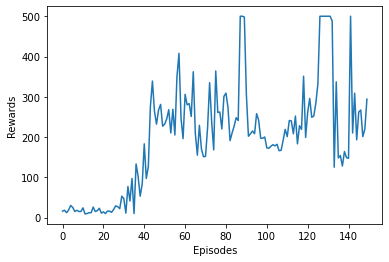

In [192]:
plot_reward_values()

In [193]:
#plot epsilon: 
def plot_epsilon_values():
    plt.plot(range(len(epsilon_values)), epsilon_values)
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon_Values')
    plt.show()

# updates the epsilon value in each episode, making it lower and lower. This makes the exploration phase happen mainly at the beginning of the training, and the exploitation phase in the remaining episodes.

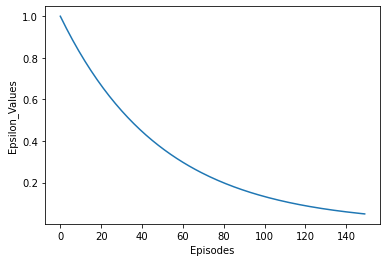

In [194]:
plot_epsilon_values()